In [295]:
from build_user_subreddit_history import read_json_list
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from networkx.algorithms import bipartite
import networkx as nx
import random
from community import community_louvain
import matplotlib.cm as cm
from datetime import datetime
from datetime import date
import datetime as dt
import seaborn as sns
import pandas as pd
from scipy import stats

spacy.prefer_gpu()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import statsmodels.formula.api as smf

# LDA Topic modeling
import numpy as np
import json
import glob
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#spacy
import spacy
import nltk
from nltk.corpus import stopwords
#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [312]:
from importlib_metadata import version
print(version('pyLDAvis'))

3.3.1


In [3]:
# select variables that I want related to the posts: content, time, author, title, subreddit
def get_contents(sub):
    
    result_dic = {}
    
    filename = "new_data/{1}/{0}/{1}_jsonlists.gz".format(sub, 'posts')
    
    i = 0
    
    for dic in read_json_list(filename):
            result = {}
            if 'selftext' in dic:
                title = dic['title']
                text = dic['selftext']
                subreddit = dic['subreddit']
                created_time = dic['created_utc']   
                if text != '[removed]'and text !='[deleted]':
                    result['text'] = title+' '+text 
                    result['time'] = datetime.utcfromtimestamp(created_time).strftime('%Y-%m-%d %H:%M:%S')
                    result['date'] = result['time'][:10]
                    result_dic[i] = result
                    i += 1
    print(i)
    return result_dic

In [4]:
workfromhome = get_contents('WorkFromHome')

10212


In [5]:
def sentiment_scores(sentence):
    
    result = 0
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
#     print("Overall sentiment dictionary is : ", sentiment_dict)
#     print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
#     print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
#     print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
#     print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.35 :
        result = "Positive"
 
    elif sentiment_dict['compound'] <= - 0.05 :
        result = "Negative"
 
    else :
        result = "Neutral"

    return result

In [6]:
positive,negative,neutral,num = 0,0,0,0
for k,v in workfromhome.items():
    workfromhome[k]["sentiment"] = sentiment_scores(v['text'])
    result = workfromhome[k]["sentiment"]
    num += 1
    if result == "Positive":
        positive += 1
    elif result == "Negative":
        negative += 1
    else:
        neutral += 1

In [7]:
# keep the [deleted]
print(positive/num,negative/num,neutral/num)

0.5738347042694869 0.14306698002350177 0.2830983157070114


In [8]:
# 2020/2021/2022
positive,negative,neutral,num = 0,0,0,0
for k,v in workfromhome.items():
    if v['date'][:4] =='2020':
        result = workfromhome[k]["sentiment"]
        num += 1
        if result == "Positive":
            positive += 1
        elif result == "Negative":
            negative += 1
        else:
            neutral += 1
    

In [9]:
# 2020
print(positive/num,negative/num,neutral/num) 

0.5623836126629422 0.11033519553072625 0.3272811918063315


In [10]:
year_month = ['2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12','2021-01','2021-02','2021-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01','2022-02','2022-03','2022-04']

In [11]:
dic = {}
for i in year_month:
    dic[i] = {}
    dic[i]['positive'] = 0
    dic[i]['negative'] = 0
    dic[i]['neutral'] = 0
    dic[i]['num'] = 0  
    for k,v in workfromhome.items():
        if v['date'][:7] == i:
            dic[i]["num"] += 1
            result = workfromhome[k]["sentiment"]
            if result == "Positive":
                dic[i]['positive'] += 1
            elif result == "Negative":
                dic[i]['negative'] += 1
            else:
                 dic[i]['neutral'] += 1
    

In [12]:
for k,v in dic.items():
    dic[k]["positive_rate"] = v['positive']/v['num']
    dic[k]["negative_rate"] = v['negative']/v['num']
    dic[k]["neutral_rate"] = v['neutral']/v['num']

In [13]:
dic

{'2020-03': {'positive': 108,
  'negative': 21,
  'neutral': 52,
  'num': 181,
  'positive_rate': 0.5966850828729282,
  'negative_rate': 0.11602209944751381,
  'neutral_rate': 0.287292817679558},
 '2020-04': {'positive': 172,
  'negative': 36,
  'neutral': 126,
  'num': 334,
  'positive_rate': 0.5149700598802395,
  'negative_rate': 0.10778443113772455,
  'neutral_rate': 0.3772455089820359},
 '2020-05': {'positive': 127,
  'negative': 31,
  'neutral': 87,
  'num': 245,
  'positive_rate': 0.5183673469387755,
  'negative_rate': 0.12653061224489795,
  'neutral_rate': 0.3551020408163265},
 '2020-06': {'positive': 105,
  'negative': 23,
  'neutral': 69,
  'num': 197,
  'positive_rate': 0.5329949238578681,
  'negative_rate': 0.116751269035533,
  'neutral_rate': 0.350253807106599},
 '2020-07': {'positive': 93,
  'negative': 13,
  'neutral': 66,
  'num': 172,
  'positive_rate': 0.5406976744186046,
  'negative_rate': 0.0755813953488372,
  'neutral_rate': 0.38372093023255816},
 '2020-08': {'posit

In [14]:
len(dic.keys())

26

In [15]:
values_num = [list(dic.values())[i]['num'] for i in range(len(dic.keys()))]

In [16]:
values_positiverate = [list(dic.values())[i]['positive_rate'] for i in range(len(dic.keys()))]

In [17]:
values_negativerate= [list(dic.values())[i]['negative_rate'] for i in range(len(dic.keys()))]

In [18]:
values_neutralrate = [list(dic.values())[i]['neutral_rate'] for i in range(len(dic.keys()))]

In [19]:
df = pd.DataFrame(year_month, columns = ['Time'])
df['Posts(num)'] = values_num
df['posts positive rate'] = values_positiverate
df['posts negative rate'] = values_negativerate
df['posts neutral rate'] = values_neutralrate

In [20]:
df

,Time,Posts(num),posts positive rate,posts negative rate,posts neutral rate
0,2020-03,181,0.596685,0.116022,0.287293
1,2020-04,334,0.514970,0.107784,0.377246
2,2020-05,245,0.518367,0.126531,0.355102
3,2020-06,197,0.532995,0.116751,0.350254
4,2020-07,172,0.540698,0.075581,0.383721
5,2020-08,188,0.531915,0.127660,0.340426
6,2020-09,184,0.565217,0.119565,0.315217
7,2020-10,207,0.618357,0.072464,0.309179
8,2020-11,212,0.636792,0.136792,0.226415
9,2020-12,228,0.596491,0.100877,0.302632


In [21]:
covid_cases = pd.read_csv('Covid-19 new cases.csv')  

In [22]:
df['US covid-19 New Cases'] = covid_cases['US New Cases']
df['Global covid-19 New Cases'] = covid_cases['Global New Cases']

In [23]:
df

,Time,Posts(num),posts positive rate,posts negative rate,posts neutral rate,US covid-19 New Cases,Global covid-19 New Cases
0,2020-03,181,0.596685,0.116022,0.287293,173235,748059
1,2020-04,334,0.514970,0.107784,0.377246,856161,2313745
2,2020-05,245,0.518367,0.126531,0.355102,756578,2896112
3,2020-06,197,0.532995,0.116751,0.350254,820214,4285155
4,2020-07,172,0.540698,0.075581,0.383721,1883014,7046657
5,2020-08,188,0.531915,0.127660,0.340426,1524956,8312083
6,2020-09,184,0.565217,0.119565,0.315217,1202102,8720743
7,2020-10,207,0.618357,0.072464,0.309179,1816173,12408194
8,2020-11,212,0.636792,0.136792,0.226415,4375472,17073932
9,2020-12,228,0.596491,0.100877,0.302632,6171889,19067884


In [ ]:
df.to_csv('reddits sentiment and covid-19.csv')

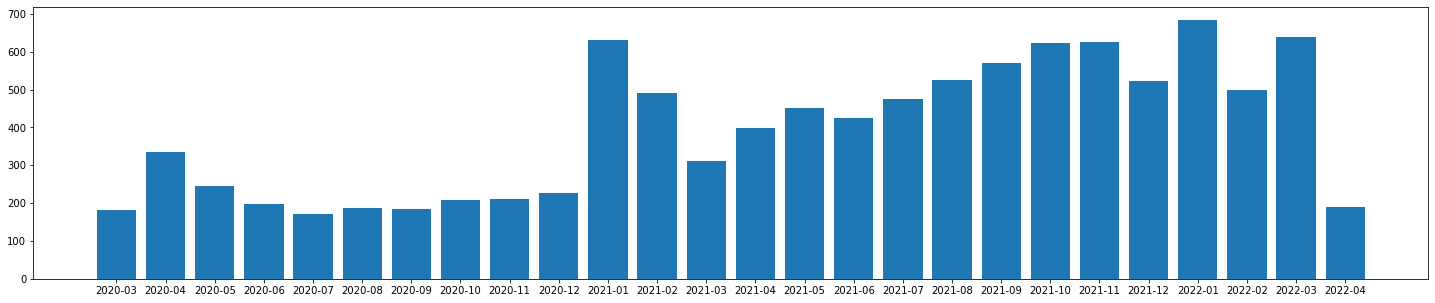

In [25]:
plt.figure(figsize=(25,5))
pl = plt.bar(list(dic.keys()),values_num)

In [270]:
d = { "x": df['US covid-19 New Cases'], "y": df['posts positive rate']}
new_df = pd.DataFrame(d)
mod = smf.ols('y ~ x', data=new_df)

In [271]:
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     3.310
Date:                Sun, 24 Apr 2022   Prob (F-statistic):             0.0814
Time:                        21:46:25   Log-Likelihood:                 46.415
No. Observations:                  26   AIC:                            -88.83
Df Residuals:                      24   BIC:                            -86.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5612      0.011     53.077      0.0

In [269]:
d = { "x": df['US covid-19 New Cases'], "y": df['posts neutral rate']}
new_df = pd.DataFrame(d)
mod = smf.ols('y ~ x', data=new_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     3.418
Date:                Sun, 24 Apr 2022   Prob (F-statistic):             0.0768
Time:                        21:46:08   Log-Likelihood:                 42.788
No. Observations:                  26   AIC:                            -81.58
Df Residuals:                      24   BIC:                            -79.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3054      0.012     25.127      0.0

In [313]:
d = { "x": df['US covid-19 New Cases'], "y": df['posts negative rate']}
new_df = pd.DataFrame(d)
mod = smf.ols('y ~ x', data=new_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                    0.1931
Date:                Sun, 24 Apr 2022   Prob (F-statistic):              0.664
Time:                        22:48:12   Log-Likelihood:                 55.798
No. Observations:                  26   AIC:                            -107.6
Df Residuals:                      24   BIC:                            -105.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1334      0.007     18.096      0.0

In [274]:
from scipy.stats import pearsonr
corr = pearsonr(df['Global covid-19 New Cases'],df['posts positive rate'])
print(corr)
# corr(df['Global covid-19 New Cases'],df['posts neutral rate'])

(0.4539949765325788, 0.01982171342881464)


In [275]:
corr = pearsonr(df['Global covid-19 New Cases'],df['posts neutral rate'])
print(corr)

(-0.573945194353964, 0.002170561973394867)


In [267]:
corr = pearsonr(df['US covid-19 New Cases'],df['posts negative rate'])
print(corr)

(0.089343337847659, 0.6642680424796233)


In [273]:
corr = pearsonr(df['Global covid-19 New Cases'],df['Posts(num)'])
print(corr)

(0.5670891324077949, 0.0025194702497152335)


In [32]:
# # LDA Topic modeling
# #https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
# import numpy as np
# import json
# import glob
# #Gensim
# import gensim
# import gensim.corpora as corpora
# from gensim.utils import simple_preprocess
# from gensim.models import CoherenceModel
# #spacy
# import spacy
# import nltk
# from nltk.corpus import stopwords
# #vis
# import pyLDAvis
# import pyLDAvis.gensim_models as gensim_models
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [33]:
workfromhome1 = []
for k,v in workfromhome.items():
    workfromhome1.append(v['text'])

In [43]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    raw_texts = []
    for text in texts:
        raw_texts.append(text)
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        final = re.sub('https?:[^\s]+', '', final)
        texts_out.append(final)
    return texts_out,raw_texts


In [44]:
lemmatized_texts, raw_texts = lemmatization(workfromhome1)

In [36]:
workfromhome1[:10]

['Making it easy for everyone ',
 'Resume example? Trying to apply for at home work &amp; need to overhaul my resume. Anyone have any examples that can help me out?',
 'Need Legit Work from Home Sites Anyone know of any legitimate work from home sites that I can browse?',
 'Work from home will improve your mental health ',
 'Has anyone faced this situation in team call ? I was in slack call with my team members and heard moaning from one team member. How clueless one can be to not use the mute option ',
 "Suggestions for a 2nd WFH job.. I have the opportunity to take a 3rd shift job that pretty much just requires me to be there if needed throughout the night. So I'm looking into trying to find something else I can do while I'm there on my laptop that doesn't require talking. I'm very computer savvy and even have an A+ IT certification. So any suggestions for something I can do would be much appreciated!",
 'Why Working From Home Doesn’t Work for Many Employees ',
 "does anyone use vpn 

In [45]:
lemmatized_texts[:10]

['make easy',
 'resume example try apply home work need overhaul resume example help',
 'need home know legitimate work home site browse',
 'work home improve mental health',
 'face situation team call slack call team member hear moaning team member clueless one use mute option',
 'suggestion 2nd wfh job opportunity take 3rd shift job pretty much just require there need night so look try find else there laptop require talk very computer savvy even a+ it certification so suggestion much appreciate',
 'work work many employee',
 'use vpn satellite internet so house shopping just find really nice house work home high speed internet there vpn connect day connect remote desktop video call use vpn satellite work decent stuff remote desktop video zoom call',
 'wfh scam apply job lately get text message work home job pay hour seem little high completely unrealistic first red flag texte directly instead email message job board second red flag interview chat video chat just text couple little er

In [46]:
raw_texts[:10]

['Making it easy for everyone ',
 'Resume example? Trying to apply for at home work &amp; need to overhaul my resume. Anyone have any examples that can help me out?',
 'Need Legit Work from Home Sites Anyone know of any legitimate work from home sites that I can browse?',
 'Work from home will improve your mental health ',
 'Has anyone faced this situation in team call ? I was in slack call with my team members and heard moaning from one team member. How clueless one can be to not use the mute option ',
 "Suggestions for a 2nd WFH job.. I have the opportunity to take a 3rd shift job that pretty much just requires me to be there if needed throughout the night. So I'm looking into trying to find something else I can do while I'm there on my laptop that doesn't require talking. I'm very computer savvy and even have an A+ IT certification. So any suggestions for something I can do would be much appreciated!",
 'Why Working From Home Doesn’t Work for Many Employees ',
 "does anyone use vpn 

In [47]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

In [48]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=30)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=30)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['make', 'easy']


In [49]:
stopwords = stopwords.words("english")

In [50]:
#modify plan 3
word_lst = ['get','just','go','so','do','take','make','give','vs','also','let','th','amp','etc','ve',"seem", "think","look","thing","else","already","turn","way","see","say","one","come","bit","actually","set","put","sure","lot","even","maybe","whole","ensure","co"]

In [51]:
new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)

In [52]:
# modify plan 5: change words
#covid = coronavirus , covid = pandemic, workfromhome = wfh, remote = remotely,desktop = laptop = pc,kid=child

new_data_bigrams_trigrams = []
for lst in data_bigrams_trigrams:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
#             elif i == 'desktop':
#                 new_lst.append('laptop')
#             elif i == 'child':
#                 new_lst.append('kid')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams.append(new_lst)


In [53]:
data_bigrams_trigrams = new_data_bigrams_trigrams

In [54]:
# Method 2
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.1
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [67]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [68]:
# 12 topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.220605  0.389932       1        1  15.089553
5      0.058828  0.454485       2        1  12.253068
7      0.457505 -0.019350       3        1  11.071024
3     -0.417892 -0.096197       4        1   9.622088
9      0.157767  0.158781       5        1   8.915744
10    -0.113242 -0.002957       6        1   8.415306
2     -0.302505 -0.336118       7        1   8.249449
11    -0.054201 -0.416603       8        1   7.159516
8     -0.397932  0.180134       9        1   5.722062
0      0.155602 -0.351063      10        1   5.529031
1      0.331386 -0.236849      11        1   4.303072
4      0.345289  0.275806      12        1   3.670088, topic_info=             Term         Freq        Total Category  logprob  loglift
4            home  3216.000000  3216.000000  Default  30.0000  30.0000
9            work  3534.000000  3534.000000  Default  29.0000  29.0000
153          time  1797.000000  1797.000000  Default  28.0000  28.0000
57         remote  2515.000000  2515.000000  Default  27.0000  27.0000
32            job  2325.000000  2325.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2392        trust    36.909933    38.139117  Topic12  -5.2435   3.2722
1309       choice    32.049034    33.278228  Topic12  -5.3848   3.2673
6712   efficiency    32.021604    33.250799  Topic12  -5.3856   3.2673
2151       submit    31.108065    32.337219  Topic12  -5.4145   3.2662
2859  financially    30.714322    31.943517  Topic12  -5.4273   3.2657

[395 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
175       2  0.992529       able
1186      3  0.993840     access
232      12  0.979999     accord
65        4  0.997931    account
66        4  0.992217    address
...     ...       ...        ...
593       4  0.996770  workspace
1004      6  0.986854      world
765       4  0.996012      worth
172       1  0.997585       year
1704     11  0.989106   year_old

[371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 4, 10, 11, 3, 12, 9, 1, 2, 5])

In [63]:
# 8 topics
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.271994  0.338205       1        1  19.948515
6      0.102451  0.421649       2        1  18.824783
3      0.414366 -0.148534       3        1  16.652317
7     -0.410160 -0.002537       4        1  11.813152
2      0.325597  0.175867       5        1   9.006165
0     -0.021240 -0.043753       6        1   8.758509
1     -0.258604 -0.334706       7        1   7.822745
4      0.119584 -0.406191       8        1   7.173815, topic_info=            Term         Freq        Total Category  logprob  loglift
9           work  3133.000000  3133.000000  Default  30.0000  30.0000
4           home  3094.000000  3094.000000  Default  29.0000  29.0000
57        remote  2371.000000  2371.000000  Default  28.0000  28.0000
32           job  2193.000000  2193.000000  Default  27.0000  27.0000
153         time  2173.000000  2173.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1816  difference    46.404042    47.476147   Topic8  -5.6849   2.6119
5338    planning    44.722233    45.795617   Topic8  -5.7218   2.6110
1246       floor    43.412949    44.485228   Topic8  -5.7515   2.6103
3340        seat    42.748182    43.819564   Topic8  -5.7669   2.6100
3924        pair    42.188652    43.262459   Topic8  -5.7801   2.6096

[278 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1186      8  0.993909     access
65        6  0.997852    account
66        5  0.994373    address
594       2  0.997487     advice
516       8  0.984584      agent
...     ...       ...        ...
1004      7  0.988397      world
2013      6  0.992313  worldwide
765       3  0.993068      worth
645       6  0.990672      write
172       2  0.998717       year

[256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 4, 8, 3, 1, 2, 5])

**Raw topics**  
Topic 1 : remote work moral  
Topic 2 : company   
Topic 3 : computer?  
Topic 4 : team work relationship coworker  
Topic 5 : money earn salary  
Topic 6 : free lifestyle (desk chair health)  
Topic 7 : life-work balance? (covid business live income dog)  
Topic 8 : productive day?  
Topic 9 : productive work?  
Topic 10 : recommendation  
Topic 11 : time management  
Topic 12 : family/home (partner sleep teacher mental_health)  

In [57]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.142211997388884

Coherence Score:  0.2925399797444031


In [58]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [59]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=20, step=2)

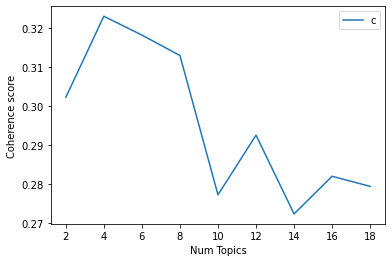

In [60]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3023
Num Topics = 4  has Coherence Value of 0.3231
Num Topics = 6  has Coherence Value of 0.3183
Num Topics = 8  has Coherence Value of 0.313
Num Topics = 10  has Coherence Value of 0.2772
Num Topics = 12  has Coherence Value of 0.2925
Num Topics = 14  has Coherence Value of 0.2723
Num Topics = 16  has Coherence Value of 0.282
Num Topics = 18  has Coherence Value of 0.2794


In [69]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=raw_texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [70]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=raw_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.2099,"remote, job, know, wfh, experience, learn, eas...",Making it easy for everyone
1,1,10.0,0.2966,"free, help, project, well, send, chair, check,...",Resume example? Trying to apply for at home wo...
2,2,6.0,0.1967,"remote, job, know, wfh, experience, learn, eas...",Need Legit Work from Home Sites Anyone know of...
3,3,4.0,0.2248,"home, hour, app, dollar, partner, internet_con...",Work from home will improve your mental health
4,4,7.0,0.2687,"use, find, try, desk, new, idea, laptop, like,...",Has anyone faced this situation in team call ?...
5,5,6.0,0.4113,"remote, job, know, wfh, experience, learn, eas...",Suggestions for a 2nd WFH job.. I have the opp...
6,6,8.0,0.2232,"work, employee, worker, productivity, study, f...",Why Working From Home Doesn’t Work for Many Em...
7,7,5.0,0.5335,"company, start, want, call, pay, video, stay, ...",does anyone use vpn through satellite internet...
8,8,10.0,0.3510,"free, help, project, well, send, chair, check,...",Another WFH Scam I have been applying for jobs...
9,9,6.0,0.2559,"remote, job, know, wfh, experience, learn, eas...",Good secondary WFH job? My job of 10 years mov...


In [71]:
df_dominant_topic.head(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.2099,"remote, job, know, wfh, experience, learn, eas...",Making it easy for everyone
1,1,10.0,0.2966,"free, help, project, well, send, chair, check,...",Resume example? Trying to apply for at home wo...
2,2,6.0,0.1967,"remote, job, know, wfh, experience, learn, eas...",Need Legit Work from Home Sites Anyone know of...
3,3,4.0,0.2248,"home, hour, app, dollar, partner, internet_con...",Work from home will improve your mental health
4,4,7.0,0.2687,"use, find, try, desk, new, idea, laptop, like,...",Has anyone faced this situation in team call ?...
5,5,6.0,0.4113,"remote, job, know, wfh, experience, learn, eas...",Suggestions for a 2nd WFH job.. I have the opp...
6,6,8.0,0.2232,"work, employee, worker, productivity, study, f...",Why Working From Home Doesn’t Work for Many Em...
7,7,5.0,0.5335,"company, start, want, call, pay, video, stay, ...",does anyone use vpn through satellite internet...
8,8,10.0,0.3510,"free, help, project, well, send, chair, check,...",Another WFH Scam I have been applying for jobs...
9,9,6.0,0.2559,"remote, job, know, wfh, experience, learn, eas...",Good secondary WFH job? My job of 10 years mov...


In [72]:
lda_model[corpus[0]]

[(0, 0.053663),
 (1, 0.038101062),
 (2, 0.077103324),
 (3, 0.08539164),
 (4, 0.037456453),
 (5, 0.112633966),
 (6, 0.2098845),
 (7, 0.09880719),
 (8, 0.052032135),
 (9, 0.092105806),
 (10, 0.08188197),
 (11, 0.06093894)]

In [73]:
lda_model.show_topic(6)

[('remote', 0.08749036),
 ('job', 0.080908716),
 ('know', 0.03759153),
 ('wfh', 0.036303338),
 ('experience', 0.022908706),
 ('learn', 0.02012155),
 ('easy', 0.018089581),
 ('year', 0.018030265),
 ('thank', 0.017928233),
 ('position', 0.014586901)]

In [76]:
# 并不是一一对应的 要改df里面的topic为对应的 或者也可以不改！
print(lda_model.print_topics(num_words=5)) 

[(0, '0.056*"feel" + 0.049*"website" + 0.044*"life" + 0.042*"training" + 0.041*"task"'), (1, '0.219*"time" + 0.097*"keep" + 0.032*"customer" + 0.031*"break" + 0.030*"part"'), (2, '0.066*"covid" + 0.058*"business" + 0.029*"live" + 0.028*"income" + 0.027*"issue"'), (3, '0.050*"team" + 0.043*"people" + 0.038*"tool" + 0.037*"email" + 0.027*"account"'), (4, '0.460*"home" + 0.062*"hour" + 0.037*"app" + 0.016*"dollar" + 0.016*"partner"'), (5, '0.055*"company" + 0.051*"start" + 0.042*"want" + 0.033*"call" + 0.030*"pay"'), (6, '0.087*"remote" + 0.081*"job" + 0.038*"know" + 0.036*"wfh" + 0.023*"experience"'), (7, '0.062*"use" + 0.037*"find" + 0.035*"try" + 0.031*"desk" + 0.031*"new"'), (8, '0.324*"work" + 0.048*"employee" + 0.029*"worker" + 0.027*"productivity" + 0.024*"study"'), (9, '0.085*"money" + 0.065*"online" + 0.060*"earn" + 0.048*"good" + 0.048*"tip"'), (10, '0.062*"free" + 0.047*"help" + 0.036*"project" + 0.033*"well" + 0.032*"send"'), (11, '0.088*"day" + 0.074*"office" + 0.056*"back" +

In [184]:
print(lda_model.print_topics(num_words=30)) 

[(0, '0.056*"feel" + 0.049*"website" + 0.044*"life" + 0.042*"training" + 0.041*"task" + 0.037*"recommendation" + 0.033*"little" + 0.032*"right" + 0.029*"many" + 0.028*"follow" + 0.020*"real" + 0.018*"base" + 0.018*"information" + 0.017*"small" + 0.017*"struggle" + 0.016*"recent" + 0.015*"lockdown" + 0.014*"top" + 0.013*"scam" + 0.012*"suppose" + 0.011*"lead" + 0.011*"fun" + 0.011*"view" + 0.010*"social" + 0.010*"contact" + 0.010*"regular" + 0.009*"text" + 0.008*"communicate" + 0.008*"comfort" + 0.007*"burn"'), (1, '0.219*"time" + 0.097*"keep" + 0.032*"customer" + 0.031*"break" + 0.030*"part" + 0.029*"schedule" + 0.026*"full" + 0.026*"manage" + 0.022*"music" + 0.021*"point" + 0.021*"quality" + 0.018*"routine" + 0.014*"around" + 0.014*"fear" + 0.013*"least" + 0.013*"year_old" + 0.010*"spend" + 0.010*"normal" + 0.009*"return" + 0.009*"habit" + 0.009*"exercise" + 0.008*"healthy" + 0.008*"second" + 0.008*"game" + 0.008*"contact_center" + 0.007*"policy" + 0.007*"clock" + 0.006*"mother" + 0.0

In [75]:
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.220605  0.389932       1        1  15.089554
5      0.058828  0.454485       2        1  12.253069
7      0.457505 -0.019350       3        1  11.071024
3     -0.417892 -0.096197       4        1   9.622087
9      0.157767  0.158781       5        1   8.915744
10    -0.113242 -0.002957       6        1   8.415308
2     -0.302505 -0.336118       7        1   8.249442
11    -0.054201 -0.416603       8        1   7.159526
8     -0.397932  0.180134       9        1   5.722059
0      0.155602 -0.351063      10        1   5.529027
1      0.331386 -0.236849      11        1   4.303073
4      0.345289  0.275806      12        1   3.670086, topic_info=             Term         Freq        Total Category  logprob  loglift
4            home  3216.000000  3216.000000  Default  30.0000  30.0000
9            work  3534.000000  3534.000000  Default  29.0000  29.0000
153          time  1797.000000  1797.000000  Default  28.0000  28.0000
57         remote  2515.000000  2515.000000  Default  27.0000  27.0000
32            job  2325.000000  2325.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2392        trust    36.909919    38.139102  Topic12  -5.2435   3.2722
1309       choice    32.049022    33.278215  Topic12  -5.3848   3.2673
6712   efficiency    32.021592    33.250787  Topic12  -5.3856   3.2673
2151       submit    31.108053    32.337207  Topic12  -5.4145   3.2662
2859  financially    30.714310    31.943505  Topic12  -5.4273   3.2657

[395 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
175       2  0.992529       able
1186      3  0.993840     access
232      12  0.979999     accord
65        4  0.997931    account
66        4  0.992217    address
...     ...       ...        ...
593       4  0.996770  workspace
1004      6  0.986853      world
765       4  0.996012      worth
172       1  0.997585       year
1704     11  0.989106   year_old

[371 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 4, 10, 11, 3, 12, 9, 1, 2, 5])

Topic 1 : remote work experience  ---6   Top-30 Most Relevant Terms for Topic 1 (15.1% of tokens)   
Topic 2 : company ---5   12.3%   
Topic 3 : (computer? desk) tech equipment ---7  11.1%  
Topic 4 : team work relationship coworker ---3  9.6%  
Topic 5 : money earn salary ----9  8.9%  
Topic 6 : not free lifestyle (standing_desk chair health) equipment + health ----10  8.4%  
Topic 7 : life-work balance? (covid business live income dog) ----2  8.2%  
Topic 8 : productive day? ----11  7.2%  
Topic 9 : productive work? ----8  5.7%   
Topic 10 : recommendation ----0   5.5%  
Topic 11 : time management ----1  4.3%  
Topic 12 : family/home (partner sleep teacher mental_health) ----4   3.7%  

In [77]:
len(df_dominant_topic)

10212

In [121]:
df_dominant_topic.iloc[1,4]

'Resume example? Trying to apply for at home work &amp; need to overhaul my resume. Anyone have any examples that can help me out?'

In [122]:
topic_dic = {}
for row in range(len(df_dominant_topic)):
    if df_dominant_topic.iloc[row,2] >0.2:
        if df_dominant_topic.iloc[row,1] not in topic_dic.keys():
            topic_dic[df_dominant_topic.iloc[row,1]]=[]
        topic_dic[df_dominant_topic.iloc[row,1]].append(df_dominant_topic.iloc[row,4])

In [161]:
def sentiment_scores(sentence):
    
    result = 0
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
#     print("Overall sentiment dictionary is : ", sentiment_dict)
#     print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
#     print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
#     print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
 
#     print("Sentence Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.35 :
        result = "Positive"
 
    elif sentiment_dict['compound'] <= - 0.05 :
        result = "Negative"
 
    else :
        result = "Neutral"

    return result,sentiment_dict['compound']

In [211]:
print(sentiment_scores(topic_dic[4][12]))
topic_dic[11]

('Positive', 0.3847)


['Need to vent My employer is trying to get us back in the office for 2 days a week I mean I understand they are doing it our well being and In person communication is key but come on we have been “working” from home the past 2 years. It’s been a dream I get to sleep in no commute I’ve watched literally everything on netflix. I’ve done all the things I’ve always wanted to but always held off because work got in the way. For years big corps have been sitting on there asses making crazy money off our work. I think it’s our turn to sit at home and collect cheques. I just don’t get it’s so frustrating I did everything right I played the whole “ oh I’m so productive this is so much better the the office ” card but they didn’t bite. I don’t know what to do I feel like I’m gonna melt down, 2 years at home “working” collecting a cheque every Friday and now it’s over I actually have to go in and be productive. God help me 😪😪😢😭😖😟',
 "Extraverted boss wants me back in the office. How do I tell he

In [133]:
topic_sentiment_dic = {}
for k,v in topic_dic.items():
    topic_sentiment_dic[k]={}
    topic_sentiment_dic[k]["Positive"] = 0
    topic_sentiment_dic[k]["Neutral"] = 0
    topic_sentiment_dic[k]["Negative"] = 0
    topic_sentiment_dic[k]["Num"] = 0    
    for i in v:
        topic_sentiment_dic[k]["Num"] += 1 
        if sentiment_scores(i) =="Positive":
            topic_sentiment_dic[k]["Positive"] +=1
        elif sentiment_scores(i) =="Neutral":
            topic_sentiment_dic[k]["Neutral"] +=1        
        else:
            topic_sentiment_dic[k]["Negative"] +=1    
    topic_sentiment_dic[k]["Positive Rate"] = topic_sentiment_dic[k]["Positive"]/topic_sentiment_dic[k]["Num"]
    topic_sentiment_dic[k]["Neutral Rate"] = topic_sentiment_dic[k]["Neutral"]/topic_sentiment_dic[k]["Num"]
    topic_sentiment_dic[k]["Negative Rate"] = topic_sentiment_dic[k]["Negative"]/topic_sentiment_dic[k]["Num"]
    

In [134]:
topic_sentiment_dic

{6.0: {'Positive': 1250,
  'Neutral': 393,
  'Negative': 303,
  'Num': 1946,
  'Positive Rate': 0.6423432682425488,
  'Neutral Rate': 0.20195272353545735,
  'Negative Rate': 0.15570400822199384},
 10.0: {'Positive': 204,
  'Neutral': 23,
  'Negative': 49,
  'Num': 276,
  'Positive Rate': 0.7391304347826086,
  'Neutral Rate': 0.08333333333333333,
  'Negative Rate': 0.17753623188405798},
 4.0: {'Positive': 18,
  'Neutral': 0,
  'Negative': 1,
  'Num': 19,
  'Positive Rate': 0.9473684210526315,
  'Neutral Rate': 0.0,
  'Negative Rate': 0.05263157894736842},
 7.0: {'Positive': 513,
  'Neutral': 127,
  'Negative': 107,
  'Num': 747,
  'Positive Rate': 0.6867469879518072,
  'Neutral Rate': 0.17001338688085676,
  'Negative Rate': 0.14323962516733602},
 8.0: {'Positive': 120,
  'Neutral': 17,
  'Negative': 22,
  'Num': 159,
  'Positive Rate': 0.7547169811320755,
  'Neutral Rate': 0.1069182389937107,
  'Negative Rate': 0.13836477987421383},
 5.0: {'Positive': 438,
  'Neutral': 157,
  'Negative'

In [147]:
topic_name = {6:"remote work experience",
             5:"company",
             7:"technology equipments",
             3:"team & coworkers",
             9:"money & salary",
             10:"equipment & health",
             2:"work-life balance", # lots of topics (couples work together on one desk, choose headset, work abroad, )
             11:"productive day",
             8:"productive work",
             0:"recommendation", # lots of ads , not that good
             1:"time management", # highly related with schedule topics
             4:"home & family"
             }

0: advices (lonely, productivity, hiring) (less content)

1: time schedule (less content)

2: life-style, work with family and roommates, work abroad, headset(noise) (couples work together on one desk, choose headset, work abroad,... )

3: Co-worker relationship, team build and activity, wear, boss relationship and supervise, monitor (Microsoft Teams.) and keyboards, work lonely, (good)

4: couple work from home, wfh best hours (less information, bad, could delete)

5: company’s requirement, work experience and issues in the companies, start new business, ads, (not that good, lots of topics)

6: find wfh jobs, interviews, experiences that need for wfh jobs (nearly all are finding jobs, the largest group of posts)

7: office software, headset, laptop, what on desks, wifi, microphone, standing_desk, chairs

8: work productivity, work life balance, motived, life work boundary, hybrid model, lots of surveys, why wfh does work for many? (less posts +100)

9: make money online, advs, (relatively large, but all likes advs)

10: standing_desk, desk, chairs, health

11: go back to office(people don’t want), neck/back pain and siting all day, mental and physical health, 


In [145]:
topic_sentiment_df = pd.DataFrame(columns=['dominant topic','topic name','nums','positive rate','neutral rate','negative rate'])
for i in topic_dic.keys():
    topic_sentiment_df = topic_sentiment_df.append({'dominant topic': i,'topic name':topic_name[i],'nums':len(topic_dic[i]), 'positive rate':topic_sentiment_dic[i]["Positive Rate"] ,'neutral rate':topic_sentiment_dic[i]["Neutral Rate"],'negative rate':topic_sentiment_dic[i]["Negative Rate"]}, ignore_index=True)

In [146]:
topic_sentiment_df

,dominant topic,topic name,nums,positive rate,neutral rate,negative rate
0,6.0,remote work experience,1946,0.642343,0.201953,0.155704
1,10.0,equipment & health,276,0.739130,0.083333,0.177536
2,4.0,home & family,19,0.947368,0.000000,0.052632
3,7.0,technology equipments,747,0.686747,0.170013,0.143240
4,8.0,productive work,159,0.754717,0.106918,0.138365
5,5.0,company,747,0.586345,0.210174,0.203481
6,9.0,money & salary,580,0.687931,0.255172,0.056897
7,11.0,productive day,183,0.562842,0.185792,0.251366
8,0.0,recommendation,79,0.835443,0.025316,0.139241
9,2.0,work-life balance,217,0.658986,0.124424,0.216590


In [148]:
topic_sentiment_df.to_csv('topic sentiment(wfh) raw.csv')

### split topic 11 into "back to office" and "physical health"

In [215]:
topic_11 = topic_dic[11]
lemmatized_texts11, raw_texts11 = lemmatization(topic_11)
data_words11 = gen_words(lemmatized_texts11)

#BIGRAMS AND TRIGRAMS
bigram_phrases11 = gensim.models.Phrases(data_words11, min_count=5, threshold=30)
trigram_phrases11 = gensim.models.Phrases(bigram_phrases[data_words11], threshold=30)

bigram11 = gensim.models.phrases.Phraser(bigram_phrases11)
trigram11 = gensim.models.phrases.Phraser(trigram_phrases11)

data_bigrams11 = make_bigrams(data_words11)
data_bigrams_trigrams11 = make_trigrams(data_bigrams11)

# modify plan 5: change words
#covid = coronavirus , covid = pandemic, workfromhome = wfh, remote = remotely,desktop = laptop = pc,kid=child

new_data_bigrams_trigrams11 = []
for lst in data_bigrams_trigrams11:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
#             elif i == 'desktop':
#                 new_lst.append('laptop')
#             elif i == 'child':
#                 new_lst.append('kid')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams11.append(new_lst)
    
data_bigrams_trigrams11 = new_data_bigrams_trigrams11


id2word11 = corpora.Dictionary(data_bigrams_trigrams11)
texts11 = data_bigrams_trigrams11
corpus11 = [id2word11.doc2bow(text) for text in texts11]

lda_model11 = gensim.models.ldamodel.LdaModel(corpus=corpus11,
                                           id2word=id2word11,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis11 = gensim_models.prepare(lda_model11, corpus11, id2word11, mds="mmds", R=30)
vis11

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.122220  0.046743       1        1  29.558183
0      0.023625  0.115142       2        1  26.008755
3      0.159654 -0.034462       3        1  22.940782
2     -0.061060 -0.127424       4        1  21.492279, topic_info=         Term        Freq       Total Category  logprob  loglift
29     office  309.000000  309.000000  Default  30.0000  30.0000
42       week  137.000000  137.000000  Default  29.0000  29.0000
9     commute   61.000000   61.000000  Default  28.0000  28.0000
1699     shed   22.000000   22.000000  Default  27.0000  27.0000
12        day  296.000000  296.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
581    advice   11.510523   22.072898   Topic4  -5.4933   0.8864
27       much   13.709841   50.467269   Topic4  -5.3184   0.2343
184      good   13.800427   55.221365   Topic4  -5.3118   0.1508
287       end   12.927788   45.500439   Topic4  -5.3772   0.2791
89      month   12.243119   36.901468   Topic4  -5.4316   0.4342

[301 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1065      2  0.853654  ability
154       1  0.608194     able
154       2  0.253414     able
154       4  0.101366     able
1077      3  0.768380      add
...     ...       ...      ...
45        4  0.183664     work
1899      3  0.827679  workday
47        1  0.470613     year
47        2  0.139441     year
47        4  0.366032     year

[450 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

In [216]:
topic_dic[11]

['Need to vent My employer is trying to get us back in the office for 2 days a week I mean I understand they are doing it our well being and In person communication is key but come on we have been “working” from home the past 2 years. It’s been a dream I get to sleep in no commute I’ve watched literally everything on netflix. I’ve done all the things I’ve always wanted to but always held off because work got in the way. For years big corps have been sitting on there asses making crazy money off our work. I think it’s our turn to sit at home and collect cheques. I just don’t get it’s so frustrating I did everything right I played the whole “ oh I’m so productive this is so much better the the office ” card but they didn’t bite. I don’t know what to do I feel like I’m gonna melt down, 2 years at home “working” collecting a cheque every Friday and now it’s over I actually have to go in and be productive. God help me 😪😪😢😭😖😟',
 "Extraverted boss wants me back in the office. How do I tell he

## Next step:
1. manually seperate the topic 11
2. different time of topic (wfh)

In [220]:
for i in topic_dic[11]:
    print(sentiment_scores(i))
    print(i)

('Negative', -0.5014)
Need to vent My employer is trying to get us back in the office for 2 days a week I mean I understand they are doing it our well being and In person communication is key but come on we have been “working” from home the past 2 years. It’s been a dream I get to sleep in no commute I’ve watched literally everything on netflix. I’ve done all the things I’ve always wanted to but always held off because work got in the way. For years big corps have been sitting on there asses making crazy money off our work. I think it’s our turn to sit at home and collect cheques. I just don’t get it’s so frustrating I did everything right I played the whole “ oh I’m so productive this is so much better the the office ” card but they didn’t bite. I don’t know what to do I feel like I’m gonna melt down, 2 years at home “working” collecting a cheque every Friday and now it’s over I actually have to go in and be productive. God help me 😪😪😢😭😖😟
('Positive', 0.7395)
Extraverted boss wants me

('Negative', -0.5519)
Anyone else scared their company is gonna call you back to the office? I work in IT for a medium/large organization. Been WFH half the week since a little after the pandemic started. I really love work from home and have gotten so used to it, but now with more and more things returning to how they were I am riddled with dread that any day now I'm gonna see an email calling us back to the office full time. Anyone else in a similar situation?
('Negative', -0.3546)
Can an office manager force you to come into an office? I work as an executive assistant to a partner who lives outside of the country (he hasn't been present in the office in 2+ years). Since COVID started, we switched to work from home. Now the office manager sends emails to the entire office saying "we expect to see you on 'date' ", will ask me why I wasn't present etc. This isn't school. On the org chart, I'm above her. ie. the partner I work for is second in command. 

With my work, I have minimal int

('Positive', 0.883)
Advice for asking to WFH sometimes Hi, I started a job a few months back with a super chill boss and have worked from home now and then during bad weather or when I'd be the only one in work. It's a bit of a commute to work and some days the work I do I could do all from home. So, I'd be keen to work from home like 1 day a week just to break up the week and reduce fuel costs a little. I just  don't know how to ask or phrase it to my boss without coming across like I just want a day off or like I'm not committed to the job. None of the others there have a set day working from home each week though do WFH now and then. Is there a good way to ask or phrase it without sounding lazy or taking advantage of the current climate?
('Negative', -0.6671)
How do ya'll counteract the physical toll of sitting all week? Working from home (and just on a computer all day in general, I suppose) is really taking a toll on my body lately. I try to get out and go for a walk/run every mor

('Negative', -0.7935)
Adjusting set up due to shoulder pain Recently I’ve been getting intense upper shoulder pain in my right side only. My neck and left side are fine; and I can’t figure out why or what I’m doing wrong. I know some of the general recommendations for an ergonomic workspace and I thought I was following that but something is obviously off. I wanted to check in here and ask all of you if you have any tips for how you fine tuned your space, or if you know what might be the culprit of one sided body pain. I imagine if it were my posture it wouldn’t be so specific/ localized.
('Neutral', 0.0)
Alcohol + working from home... Have your drinking habits changed working from home?? I can’t tell if I drink more or less now, but sometimes a drink at the end of a work day is needed.
('Positive', 0.9793)
Being told we are going to transition back to the office, but there is pushback... A majority of us being told we are going back feel as if working from home is one of the greatest 

('Positive', 0.7744)
Document tasks every 15 minutes?? This is what my job is requiring now for work from home 1 day every 2 weeks...its the every 15 minute increment that is funniest. For context I'm an experienced employee in my thirties.  There is no billable hours issue and we have been primarily remote for 1 year.  My boss just left on fmla so this is a lower supervisor. Isn't this a bit much?

I will process the agreement for [date]- we will need my, ____, and the CEO’s signature.  You can’t complete the certification until the end of the telework day.  On the certification, you will need to list in detail what you did during the course of the day with the time down to the quarter hour.  For example:

 

9-9:15- reviewed and responded to emails

9:30-9:45- call with ___ regarding ____

9:45-10- send follow up email regarding _____

10-11- conference call with __ about ___

 

You will also need to do the following per the new policy:

email me specifically what you will be workin

('Positive', 0.8248)
What do you use to help with neck pain? Hey guys,

My DIY home office is doing a number on my neck and upper back. I was wondering if any of you were experiencing the same issues and if you had any tips or equipment suggestions to build a more ergonomic home office.

Right now I'm just working from the kitchen table and sitting on my dining chairs (with cushions). I purchased a Roost stand a few months back, but it doesn't seem to be doing the trick.

By the end of the day my upper back is super sore and I've got pain running down my neck into my right arm.

Any advice or suggestions would be greatly appreciated. Thanks guys!
('Positive', 0.9703)
WFH but deducting travel commute question TLDR; what are your thoughts or experiences on working a mostly remote job but having to deduct a home-to-office travel commute due to company policy if you travel locally for work purposes at times?

I live in Sacramento, CA and started working a new job in January of this year an

('Neutral', 0.0)
Hey has anybody worked for transcom apple tier if so how was &amp; how was the final test after two weeks ? 
('Negative', -0.7473)
WFH Lunchtime is something else I just started a new job. I get a half hour paid lunch. 

At my old job - in fast food - my UNPAID lunch was spent sitting and staring at the wall, because it was my time to zone out. No customers. No drinks. But there was the dread of going back. Of donning a headset. Sometimes I’d forget a lunch and I’d eat some crap, processed breakfast sandwich. 

Lunch now? I took out my dog. I vacuumed. I made a healthy wrap. I snuggled my kitty. I felt re-energized. It wasn’t a break FROM work, it was a brief return to life.
('Positive', 0.992)
Work from Home Manifesto I have worked the last 2 years at home, having just started a new position before going home for COVID. This has been the best 2 years of my life. Being able to spend this much time with my family and seeing my kids grow up. I wouldn’t trade it for the w

('Neutral', 0.0)
Charlie Munger: We are never going back to a five-day work week in the office 
('Positive', 0.9876)
Lured with a private office to come back? Been with the company 15 years, same position and I take my job seriously.  I'm happy, love my job and everyone knows it. Had kids, started working from home whenever I needed to and worked from home 3-5 days per week for a few years prior to covid. Since covid, I've been to the office 3x total for meetings. 

I got a call from my boss to tell me I got s 4% raise.  Great! I was happy to get anything because I really do get paid well for what I do.  Anyway, I was thankful, honored. He then tells me that he thinks something is "coming" which would be an initiative of some sort to get everyone back in the office.  I said oh.  He then said that they're doing some moving around of offices in the office and he has an open office that I can have (I have a cubicle there that I don't use).  I'd be able to close the door if covid is still 

('Positive', 0.9047)
Newbie Friendly Method Reveals How We Make $128+ Per Day With FREE Traffic In Just 30 Minutes Per Day!....if you are interested leave ok in the comment 
('Neutral', 0.237)
Anyone have an elaborate Packing system for WFH gear? Have to pack to work from the corporate office.  WFH but one week a quarter I am contractually obligated to work at the corporate office (it's six hours drive away)

How do you pack your WFH gear?

Just looking at my desk at home office, I'd like to bring everything but it won't fit in a small laptop bag.

Looking for tips and ideas..
('Neutral', 0.1775)
Just got hired at a company paying me $32/hr after completely &amp; utterly lying on every aspect of my resume I’m 26 and have worked absolutely nothing but labor jobs for probably the past 7 years. From landscaping, fencing, roofing, to repairing &amp; restoring tennis &amp; basketball courts. 

I was introduced to WFH through my ex last year. We had started spending a lot of time together an

('Neutral', 0.264)
Is going back to the office a good idea?? I have been thinking about working from the office from far back. However, now working from home is way too convenient and going back to the office seems to be a scary dream.
('Positive', 0.4621)
Tips for sitting on the ground all day? I recently realized that I probably have ADHD and as you can imagine this makes staying productive while working from home pretty difficult. I've come up with so many accommodations for myself and the most recent one was switching from a standard desk to a floor setup. It's helping my productivity immensely because I just feel more at ease and focused when I sit on the floor.

The only problem is that I'm starting to get numbness in my thigh, probably because something in my hip is getting pinched from sitting cross legged all day. There's no way I'm going back to sitting in a normal chair, so I was wondering if anyone else works from the floor and has tips for not ruining your body while doing

('Neutral', 0.0)
Half of London firms plan for home working five days a week 
('Positive', 0.9337)
Work Hard, Play Harder😉 have you seen my toy anywhere😈 cum check out more, link in comments 🥰😘 
('Negative', -0.7399)
does anyone else do literally nothing while working from home or is it just me??? i do get work done but often i just do whatever i want around the house whether it’s cleaning or skincare or yoga or watching youtube. i just wiggle the mouse around once in awhile and give my boss one deliverable or so a day so he knows stuff is getting done. i work hard for about 2 1/2 - 3 1/2 hours then i fake work and chiiiilllll. anyone else???
('Negative', -0.7399)
does anyone else do literally nothing while working from home or is it just me??? i do get work done but often i just do whatever i want around the house whether it’s cleaning or skincare or yoga or watching youtube. i just wiggle the mouse around once in awhile and give my boss one deliverable or so a day so he knows stuff i

('Negative', -0.7506)
New Mom forced back to office? My daughter just went back to work for large company after having a baby. She was sent to WFH last March. Today she was told they’re starting to bring people back into the office (untrue - management is still home/parking lot nearly deserted) and will have to be back in the office Monday. She has no childcare, is breastfeeding and is unvaccinated. 

Any thoughts on how to avoid. I feel she’s being targeted.
('Negative', -0.1531)
End of day transitions What things do y'all do to transition from work at the end of the day? Typically it would be the drive home but now I find it hard to 'shut down' for the day
('Positive', 0.9654)
Meeting options when you WFH but your colleagues don't I started working from home due to COVID and oh god I love it. I knew I would love it but my workplace was biased against it. We have a new big boss, though, and he's amenable to letting me work from home 3 or 4 days a week. The only snag I can think of, an

('Positive', 0.9995)
The Advantages of Having a Backyard Office Working from home has become the new normal, especially since COVID-19. The situation might not change as quickly as we want it to be and all we can do is try to adapt and learn how to balance work and personal life under one roof.

Finding the right space that will allow you to concentrate on your work, conduct [effective business meetings ](https://blog.mombit.io/business-meeting-agenda-template/)and fulfill all of your professional duties has become a priority for many employees all over the world. Setting up your office at the kitchen table, in the kid’s room or in the cramped basement can’t simply cut it. If you’re going to work remotely, you will need that peace and quiet, especially if the whole family is staying at home 24/7 due to COVID-19 restrictions.

That’s how the backyard office became one of the most popular solutions to our trendy work from home problems. When the whole family works from home and the kids 

('Positive', 0.9997)
How to Stay Productive While Working From Home I wrote this as an article and thought to post this here too. What tips do you use to stay productive while working from home? 

\----

# How to Stay Productive While Working From Home

Working from home can be a dream. It can also be very challenging. Since the world seems to be adopting a work from home mindset, I wanted to share some tips on how to stay productive while working from home that I have found helpful over the years.

## Take Time to Prepare

When working from home, you must prepare for the day ahead. You don’t want to be caught like a deer in headlights when your alarm clock rings. Think about it. You are working from ‘home.’ Your home is a place of rest, relaxation, and distractions. Generally speaking, a home is not a place designed for maximum deep work and productivity – it’s a jungle.

Now that we have established that our homes are a minefield of personal and professional obstacles, it is easy to 

## Topic Modeling in Different Time 

In [221]:
workfromhome20 = get_contents('WorkFromHome20')

2137


In [222]:
workfromhome21 = get_contents('WorkFromHome21')

3016


In [223]:
workfromhome22 = get_contents('WorkFromHome22')

1007


### 2020

In [244]:
workfromhome2020 = []
for k,v in workfromhome20.items():
    workfromhome2020.append(v['text'])
    
lemmatized_texts20, raw_texts20 = lemmatization(workfromhome2020)
data_words20 = gen_words(lemmatized_texts20)

#BIGRAMS AND TRIGRAMS
bigram_phrases20 = gensim.models.Phrases(data_words20, min_count=5, threshold=30)
trigram_phrases20 = gensim.models.Phrases(bigram_phrases[data_words20], threshold=30)

bigram20 = gensim.models.phrases.Phraser(bigram_phrases20)
trigram20 = gensim.models.phrases.Phraser(trigram_phrases20)

data_bigrams20 = make_bigrams(data_words20)
data_bigrams_trigrams20 = make_trigrams(data_bigrams20)

# modify plan 5: change words
#covid = coronavirus , covid = pandemic, workfromhome = wfh, remote = remotely,desktop = laptop = pc,kid=child

new_data_bigrams_trigrams20 = []
for lst in data_bigrams_trigrams20:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
#             elif i == 'desktop':
#                 new_lst.append('laptop')
#             elif i == 'child':
#                 new_lst.append('kid')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams20.append(new_lst)
    
data_bigrams_trigrams20 = new_data_bigrams_trigrams20


id2word20 = corpora.Dictionary(data_bigrams_trigrams20)
texts20 = data_bigrams_trigrams20
corpus20 = [id2word20.doc2bow(text) for text in texts20]

lda_model20 = gensim.models.ldamodel.LdaModel(corpus=corpus20,
                                           id2word=id2word20,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis20 = gensim_models.prepare(lda_model20, corpus20, id2word20, mds="mmds", R=30)
vis20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.094350  0.402900       1        1  55.248905
2     -0.346125  0.095810       2        1  13.991349
1      0.349301 -0.124419       3        1  10.359766
7      0.278883  0.228836       4        1   8.494387
3     -0.227410 -0.262453       5        1   6.391983
0      0.071071 -0.291674       6        1   2.888192
5     -0.004158  0.036110       7        1   1.679832
6     -0.027213 -0.085109       8        1   0.945586, topic_info=         Term         Freq        Total Category  logprob  loglift
11       work  3273.000000  3273.000000  Default  30.0000  30.0000
23       home  2061.000000  2061.000000  Default  29.0000  29.0000
63      money   259.000000   259.000000  Default  28.0000  28.0000
30     online   265.000000   265.000000  Default  27.0000  27.0000
500      team   234.000000   234.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
5287  drought     1.700840     2.521927   Topic8  -5.7492   4.2672
2776  outcome     1.658671     2.474178   Topic8  -5.7743   4.2612
568     title     1.637388     2.449954   Topic8  -5.7872   4.2582
2379   pajama     1.631964     2.445755   Topic8  -5.7906   4.2566
3606  initial     4.036520     7.829797   Topic8  -4.8850   3.9986

[332 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5884      6  0.973191    academy
701       7  0.916708     accept
529       4  0.987190    account
463       2  0.992719   activity
1517      4  0.959258    address
...     ...       ...        ...
688       2  0.985048  workspace
3169      6  0.926036  worldwide
1715      4  0.978160      worth
52        1  0.993409       year
1787      5  0.959963   year_old

[364 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 8, 4, 1, 6, 7])

In [235]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus20))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda20 = CoherenceModel(model=lda_model20, texts=texts20, dictionary=id2word20, coherence='c_v')
coherence_lda20 = coherence_model_lda20.get_coherence()
print('\nCoherence Score: ', coherence_lda20)


Perplexity:  -12.33428242382207

Coherence Score:  0.45049024561259604


In [245]:
print(lda_model20.print_topics(num_words=30)) 

[(0, '0.033*"link" + 0.024*"real" + 0.024*"monitor" + 0.022*"quick" + 0.022*"setup" + 0.019*"software" + 0.018*"collegue" + 0.018*"snack" + 0.017*"partner" + 0.015*"cash" + 0.013*"recession" + 0.013*"regard" + 0.013*"scam" + 0.013*"stand" + 0.013*"community" + 0.013*"resource" + 0.012*"product" + 0.010*"worldwide" + 0.010*"department" + 0.009*"academy" + 0.008*"together" + 0.008*"development" + 0.008*"human" + 0.007*"blog" + 0.007*"beginner" + 0.007*"watch_video" + 0.006*"commute" + 0.006*"supplier" + 0.006*"mod" + 0.006*"keyboard"'), (1, '0.040*"team" + 0.032*"business" + 0.028*"tool" + 0.024*"email" + 0.017*"video" + 0.014*"sign" + 0.013*"interested" + 0.013*"ask" + 0.013*"person" + 0.011*"income" + 0.011*"training" + 0.011*"easy" + 0.010*"follow" + 0.009*"customer" + 0.008*"meeting" + 0.008*"receive" + 0.008*"boss" + 0.008*"quarantine" + 0.008*"pretty" + 0.007*"step" + 0.007*"coworker" + 0.007*"store" + 0.007*"build" + 0.007*"schedule" + 0.007*"sale" + 0.006*"ready" + 0.006*"success

In [249]:
df_topic_sents_keywords20 = format_topics_sentences(ldamodel=lda_model20, corpus=corpus20, texts=raw_texts20)

# Format
df_dominant_topic20 = df_topic_sents_keywords20.reset_index()
df_dominant_topic20.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic20.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5784,"work, home, time, remote, job, need, good, kno...",WFH suggestions for health care professional L...
1,1,4.0,0.8635,"work, home, time, remote, job, need, good, kno...",Out of job and stuck home due to COVID I recen...
2,2,4.0,0.8752,"work, home, time, remote, job, need, good, kno...",I don't even know where to start I'm looking t...
3,3,4.0,0.4680,"work, home, time, remote, job, need, good, kno...",Work from your phone Earn money from your mobi...
4,4,4.0,0.5455,"work, home, time, remote, job, need, good, kno...","Scheduled shifts? For those wfh, does your bos..."
5,5,4.0,0.7368,"work, home, time, remote, job, need, good, kno...",List and search for remote and work from home ...
6,6,4.0,0.7398,"work, home, time, remote, job, need, good, kno...",The economics of remote work: What we can do a...
7,7,4.0,0.6246,"work, home, time, remote, job, need, good, kno...",Does working from home make employees more pro...
8,8,4.0,0.7204,"work, home, time, remote, job, need, good, kno...",7 Reasons why 2021 will be even bigger and bet...
9,9,4.0,0.7834,"work, home, time, remote, job, need, good, kno...",Does anyone know if Bridgestone has work at ho...


In [260]:
topic_dic20 = {}
for row in range(len(df_dominant_topic20)):
    if df_dominant_topic20.iloc[row,2] >0.1:
        if df_dominant_topic20.iloc[row,1] not in topic_dic20.keys():
            topic_dic20[df_dominant_topic20.iloc[row,1]]=[]
        topic_dic20[df_dominant_topic20.iloc[row,1]].append(df_dominant_topic20.iloc[row,4])

In [262]:
topic_dic20[0]

['Generate earning at your home What is Google Adsense? Earning Generator Tool \n\nIt is a program for those that create content to monetize\n\ntheir work. Advertisers bid for cost per click to their websites and Google pays you for\n\ntraffic coming from your blog. You are providing a space for other advertisers in your\n\nniche to get their products seen in the form a banner on your blog.\n\n[Click and learn how to use and generate earning](https://www.worldknowledge11.com/2020/07/How%20to%20Earn%20Money%20Online%202020%20-%20Work%20at%20home%20%20earn%20without%20investment.html)',
 'Way to create keyboard tray from desk drawer Any ideas on how to create a keyboard tray from a desk drawer? I bought this desk without realizing I need a keyboard tray as I\'m using the desk to work from home. The dimensions of one of the drawers is 2.1"H X 17.87"W X 13.3"D.\n\nhttps://preview.redd.it/e7b7g7yuy2951.png?width=834&amp;format=png&amp;auto=webp&amp;s=f8cf8a8d0474fc1b195990c79307946e098dbcc1

#### Advice: manually classify the topic

### 2021

In [238]:
workfromhome2021 = []
for k,v in workfromhome21.items():
    workfromhome2021.append(v['text'])
    
lemmatized_texts21, raw_texts21 = lemmatization(workfromhome2021)
data_words21 = gen_words(lemmatized_texts21)

#BIGRAMS AND TRIGRAMS
bigram_phrases21 = gensim.models.Phrases(data_words21, min_count=5, threshold=30)
trigram_phrases21 = gensim.models.Phrases(bigram_phrases[data_words21], threshold=30)

bigram21 = gensim.models.phrases.Phraser(bigram_phrases21)
trigram21 = gensim.models.phrases.Phraser(trigram_phrases21)

data_bigrams21 = make_bigrams(data_words21)
data_bigrams_trigrams21 = make_trigrams(data_bigrams21)

# modify plan 5: change words
#covid = coronavirus , covid = pandemic, workfromhome = wfh, remote = remotely,desktop = laptop = pc,kid=child

new_data_bigrams_trigrams21 = []
for lst in data_bigrams_trigrams21:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
#             elif i == 'desktop':
#                 new_lst.append('laptop')
#             elif i == 'child':
#                 new_lst.append('kid')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams21.append(new_lst)
    
data_bigrams_trigrams21 = new_data_bigrams_trigrams21


id2word21 = corpora.Dictionary(data_bigrams_trigrams21)
texts21 = data_bigrams_trigrams21
corpus21 = [id2word21.doc2bow(text) for text in texts21]

lda_model21 = gensim.models.ldamodel.LdaModel(corpus=corpus21,
                                           id2word=id2word21,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis21 = gensim_models.prepare(lda_model21, corpus21, id2word21, mds="mmds", R=30)
vis21

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.043801  0.446658       1        1  48.825485
1     -0.092254 -0.390223       2        1  16.154093
6     -0.361839 -0.141590       3        1  13.358996
2     -0.291185  0.177869       4        1   7.697955
0      0.274606 -0.269869       5        1   6.834357
5      0.333146  0.031455       6        1   3.791334
4      0.166376  0.173312       7        1   2.354539
3      0.014952 -0.027611       8        1   0.983241, topic_info=                  Term         Freq        Total Category  logprob  loglift
15                work  3909.000000  3909.000000  Default  30.0000  30.0000
6                 home  2351.000000  2351.000000  Default  29.0000  29.0000
120               time   934.000000   934.000000  Default  28.0000  28.0000
63                 job  1850.000000  1850.000000  Default  27.0000  27.0000
13                 use   595.000000   595.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
2213        collection     3.393471     4.214787   Topic8  -5.5050   4.4053
3013          shoulder     3.375927     4.195968   Topic8  -5.5102   4.4046
1631              spec     3.200544     4.021431   Topic8  -5.5636   4.3938
4141  external_monitor     3.167642     3.989298   Topic8  -5.5739   4.3914
5966         neck_pain     3.397694     4.338131   Topic8  -5.5038   4.3777

[308 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
675       1  0.993020     able
677       5  0.992308  account
197       7  0.971581       ad
825       3  0.986394      add
0         1  0.993196   advice
...     ...       ...      ...
2230      7  0.922372   winter
15        1  0.998876     work
15        2  0.001023     work
249       2  0.990957    write
260       1  0.997771     year

[316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 7, 3, 1, 6, 5, 4])

In [242]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus21))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda21 = CoherenceModel(model=lda_model21, texts=texts21, dictionary=id2word21, coherence='c_v')
coherence_lda21 = coherence_model_lda21.get_coherence()
print('\nCoherence Score: ', coherence_lda21)


Perplexity:  -12.523287323392937

Coherence Score:  0.4427342023480241


In [246]:
print(lda_model21.print_topics(num_words=30)) 

[(0, '0.054*"money" + 0.052*"online" + 0.029*"website" + 0.027*"business" + 0.018*"account" + 0.018*"type" + 0.017*"course" + 0.016*"site" + 0.015*"interested" + 0.014*"learn" + 0.013*"skill" + 0.013*"view" + 0.013*"review" + 0.012*"graduate" + 0.011*"promote" + 0.010*"processing_video" + 0.010*"available" + 0.010*"degree" + 0.010*"anywhere" + 0.010*"increase" + 0.009*"income" + 0.008*"willing" + 0.008*"grow" + 0.008*"sub" + 0.008*"comment" + 0.008*"code" + 0.008*"out_there" + 0.008*"client" + 0.008*"recommend" + 0.007*"simple"'), (1, '0.062*"time" + 0.033*"free" + 0.030*"hour" + 0.025*"pay" + 0.024*"week" + 0.019*"earn" + 0.017*"day" + 0.016*"life" + 0.014*"part" + 0.012*"month" + 0.012*"full" + 0.011*"people" + 0.011*"appreciate" + 0.010*"project" + 0.010*"create" + 0.009*"opportunity" + 0.008*"link" + 0.008*"offer" + 0.008*"research" + 0.008*"training" + 0.008*"platform" + 0.007*"minute" + 0.007*"leave" + 0.007*"care" + 0.006*"pass" + 0.006*"join" + 0.006*"schedule" + 0.006*"career"

### 2022

In [240]:
workfromhome2022 = []
for k,v in workfromhome22.items():
    workfromhome2022.append(v['text'])
    
lemmatized_texts22, raw_texts22 = lemmatization(workfromhome2022)
data_words22 = gen_words(lemmatized_texts22)

#BIGRAMS AND TRIGRAMS
bigram_phrases22 = gensim.models.Phrases(data_words22, min_count=5, threshold=30)
trigram_phrases22 = gensim.models.Phrases(bigram_phrases[data_words22], threshold=30)

bigram22 = gensim.models.phrases.Phraser(bigram_phrases22)
trigram22 = gensim.models.phrases.Phraser(trigram_phrases22)

data_bigrams22 = make_bigrams(data_words22)
data_bigrams_trigrams22 = make_trigrams(data_bigrams22)

# modify plan 5: change words
#covid = coronavirus , covid = pandemic, workfromhome = wfh, remote = remotely,desktop = laptop = pc,kid=child

new_data_bigrams_trigrams22 = []
for lst in data_bigrams_trigrams22:
    new_lst = []
    for i in lst:
        if i not in word_lst and i not in stopwords:
            if i == 'coronavirus' or i == 'pandemic':
                new_lst.append('covid')
            elif i == 'workfromhome':
                new_lst.append('wfh')
            elif i == 'remotely':
                new_lst.append('remote')
#             elif i == 'desktop':
#                 new_lst.append('laptop')
#             elif i == 'child':
#                 new_lst.append('kid')
            elif i == 'stand_desk':
                new_lst.append('standing_desk')
            else:
                new_lst.append(i)
    new_data_bigrams_trigrams22.append(new_lst)
    
data_bigrams_trigrams22 = new_data_bigrams_trigrams22


id2word22 = corpora.Dictionary(data_bigrams_trigrams22)
texts22 = data_bigrams_trigrams22
corpus22 = [id2word22.doc2bow(text) for text in texts22]

lda_model22 = gensim.models.ldamodel.LdaModel(corpus=corpus22,
                                           id2word=id2word22,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

pyLDAvis.enable_notebook()
vis22 = gensim_models.prepare(lda_model22, corpus22, id2word22, mds="mmds", R=30)
vis22

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.293887  0.295686       1        1  56.870586
7      0.105855  0.317697       2        1  17.828468
5      0.267199 -0.199498       3        1   9.615264
4     -0.233686 -0.117836       4        1   4.403876
1      0.247966  0.059363       5        1   3.783876
0     -0.047566  0.040158       6        1   3.082165
2     -0.087163 -0.227893       7        1   2.465126
3      0.041282 -0.167677       8        1   1.950638, topic_info=                       Term         Freq        Total Category  logprob  \
9                      work  1400.000000  1400.000000  Default  30.0000   
208                  office   310.000000   310.000000  Default  29.0000   
32                      job   787.000000   787.000000  Default  28.0000   
4                      home   663.000000   663.000000  Default  27.0000   
27                      use   178.000000   178.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
747                  charge     2.631541     3.409208   Topic8  -5.5415   
748  independent_contractor     2.475774     3.250777   Topic8  -5.6026   
415                    area     8.877413    14.108155   Topic8  -4.3256   
338                   money     6.661077   111.471040   Topic8  -4.6128   
7                    resume     2.968540    10.736305   Topic8  -5.4210   

     loglift  
9    30.0000  
208  29.0000  
32   28.0000  
4    27.0000  
27   26.0000  
..       ...  
747   3.6781  
748   3.6647  
415   3.4738  
338   1.1195  
7     2.6515  

[341 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
65        3  0.970358     account
1814      5  0.965728  accountant
1690      6  0.905120      actual
2539      4  0.913074          ad
66        8  0.932416     address
...     ...       ...         ...
545       6  0.889507   workplace
950       3  0.906118       worry
765       2  0.989574       worth
172       1  0.997000        year
64        7  0.751663        zoom

[390 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 6, 5, 2, 1, 3, 4])

In [241]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus22))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda22 = CoherenceModel(model=lda_model22, texts=texts22, dictionary=id2word22, coherence='c_v')
coherence_lda22 = coherence_model_lda22.get_coherence()
print('\nCoherence Score: ', coherence_lda22)


Perplexity:  -9.13252614456199

Coherence Score:  0.45559707150510426


In [247]:
print(lda_model22.print_topics(num_words=30)) 

[(0, '0.062*"update" + 0.044*"interview" + 0.029*"apply" + 0.026*"land" + 0.024*"auto" + 0.021*"goth" + 0.020*"defeat" + 0.018*"search" + 0.015*"service" + 0.012*"scared" + 0.010*"information" + 0.009*"hr" + 0.008*"luck" + 0.008*"hire" + 0.007*"wifi" + 0.007*"customer_service" + 0.007*"moment" + 0.007*"datum_entry" + 0.007*"contact" + 0.006*"equipment" + 0.006*"provide" + 0.006*"rate" + 0.006*"overwhelmed" + 0.005*"verify" + 0.005*"score" + 0.005*"preferably" + 0.005*"desperately" + 0.005*"personal_assistant" + 0.005*"extremely" + 0.005*"burnout"'), (1, '0.067*"return" + 0.028*"office" + 0.025*"manage" + 0.020*"accountant" + 0.019*"typically" + 0.018*"am_pm" + 0.018*"fulfill" + 0.018*"symptom" + 0.018*"quarantine" + 0.018*"handbook" + 0.018*"enough" + 0.012*"create" + 0.011*"employee" + 0.007*"choice" + 0.007*"super" + 0.007*"separate" + 0.007*"realize" + 0.005*"challenge" + 0.005*"legitimate" + 0.005*"distraction" + 0.005*"advantage" + 0.005*"wide" + 0.005*"alone" + 0.005*"lab" + 0.00